# Exam 1

### Using the airports data ([airports.csv](https://github.com/sjsrey/gis321f16collaboratory/blob/master/exercise04/airports.csv)) and the ([countries.geojson](https://github.com/sjsrey/gis321f16/blob/master/content/partI/countries.geojson)) file carry out the following tasks:

## Part A: Travelling Salesman

A. Given the following airports:

- Phoenix (KPHX)
- Johannesburg (FAJS)
- London (EGLL)
- New York (KJFK)
- Sydney (YSSY)

find the route with the shortest possible distance that visits each intermediate city exactly once and returns to the origin city.

Your route must specify the specific airports at each leg of the trip in their proper order. Use a great circle distance for each leg of the route.

### Imports and function definitions

Using the `pyproj` and `Shapely` modules for geometric calculations, the `json` and `csv` modules for file reading, the `itertools` module for shuffling the order of airports in a list, and the `math` module because it's generally useful.  Also copying over some useful functions from my Exercise 4/5 `points` module and adding a new great circle distance function using `pyproj`.

In [1]:
# Import useful modules and sections thereof
import pyproj
import shapely
from shapely.geometry import LineString

import csv
import json
import itertools
import math


# Set up plotting subsystem, with larger-than-default figure size
%matplotlib
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)


# New great circle distance function using PyProj
def great_circle_distance(p1, p2):
    """
    Calculate great circle distance between two points on Earth in kilometers, 
    using the WGS84 ellipsoid

    Arguments
    ---------
    p1: tuple
        First location in (longitude, latitude) order
    p2: tuple
        Second location in (longitude, latitude) order

    Returns
    -------
    distance: float
              The great circle distance betwen the two points in kilometers
    """
    g = pyproj.Geod(ellps='WGS84')
    fAz,bAz,gcd = g.inv(*p1, *p2)
    return gcd/1000
#


# Utility functions from my Points module
# read_airport_csv
# get_column_by_name

def read_airport_csv(file_name):
    """
    Load airport data from a CSV file, converting numeric columns to numbers

    Arguments
    ---------
    path: string
          Path to the CSV file to load

    Returns
    -------
    header: list
            The header row of the CSV file
    data: list
          The data rows of the CSV file
    """
    data = []
    with open(file_name, 'r') as f:
        reader = csv.reader(f) # This is an iterator
        for line in reader:
            data.append(line)
    header = data[0]
    data   = data[1:]
    
    # Fix numeric values
    lookup = dict([(v,k) for k,v in enumerate(header)])
    lat_idx = lookup['latitude']
    lon_idx = lookup['longitude']
    aptid_idx = lookup['airport_id']
    alti_idx = lookup['altitude']
    zone_idx = lookup['zone'] # Timezone (I believe relative to UTC)
    
    for line in data:
        line[aptid_idx] = int(line[aptid_idx])
        line[lat_idx]   = float(line[lat_idx])
        line[lon_idx]   = float(line[lon_idx])
        line[alti_idx]  = float(line[alti_idx])
        line[zone_idx]  = float(line[zone_idx])
    #
    
    return (header, data)
#


def get_column_by_name(header, data, attribute):
    """
    Returns a list consisting of the column associated with the given attribute name
    """
    idx = header.index(attribute)
    return [record[idx] for record in data]
#


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Extract airport records for the selected airports

In [2]:
# Load airport datafile
airportfile = "airports.csv"
header, data = read_airport_csv(airportfile)

# Airport list
airport_iaco_list = ["KPHX", "FAJS", "EGLL", "KJFK", "YSSY"]
airport_count = len(airport_iaco_list)

# Extract the airports with those identifiers
iaco_idx = header.index("iaco")
airport_list = [r for r in data if r[iaco_idx] in airport_iaco_list]

for a in airport_list:
    print(a)

[507, 'Heathrow', 'London', 'United Kingdom', 'LHR', 'EGLL', 51.4775, -0.461389, 83.0, 0.0, 'E']
[813, 'Johannesburg Intl', 'Johannesburg', 'South Africa', 'JNB', 'FAJS', -26.139166, 28.246, 5558.0, 2.0, 'U']
[3361, 'Sydney Intl', 'Sydney', 'Australia', 'SYD', 'YSSY', -33.946111, 151.177222, 21.0, 10.0, 'O']
[3462, 'Phoenix Sky Harbor Intl', 'Phoenix', 'United States', 'PHX', 'KPHX', 33.434278, -112.011583, 1135.0, -7.0, 'N']
[3797, 'John F Kennedy Intl', 'New York', 'United States', 'JFK', 'KJFK', 40.639751, -73.778925, 13.0, -5.0, 'A']


### Pre-calculate the lengths of all possible legs

In [3]:
# Get coordinates
# Conveniently, the get_column function works on subsets of the original datafile
lats = get_column_by_name(header, airport_list, "latitude")
lons = get_column_by_name(header, airport_list, "longitude")
coords = list(zip(lons,lats))

# Pre-calculate the distance of each possible leg 
# Initialize a list of lists of 0s; will be filled as leg_lengths[start_idx][end_idx] = dist
leg_lengths=[[0 for x in range(airport_count)] for k in range(len(coords))]
for idx1 in range(airport_count):
    for idx2 in range(idx1+1, airport_count):
        d = great_circle_distance(coords[idx1], coords[idx2])
        leg_lengths[idx1][idx2] = d
        leg_lengths[idx2][idx1] = d
#

# Print out the resulting matrix
print("Distance matrix:")
for row in leg_lengths:
    print(list(map(int,row)))

Distance matrix:
[0, 9045, 17015, 8482, 5554]
[9045, 0, 11043, 16124, 12824]
[17015, 11043, 0, 12550, 16012]
[8482, 16124, 12550, 0, 3465]
[5554, 12824, 16012, 3465, 0]


### Get the ordering that produces the shortest path

### (Answer)

In [4]:
# For each permutation of ordering, get total distance
# http://stackoverflow.com/questions/104420/how-to-generate-all-permutations-of-a-list-in-python#104471

shortest_order = []
shortest_distance = math.inf
shortest_distance_list = []
for ordering in itertools.permutations(range(airport_count)):
    # Get length of each leg from the pre-built table, sum
    distance_list = [leg_lengths[ordering[i]][ordering[i-1]] for i in range(len(ordering))]
    distance = sum(distance_list)
    
    # Update best route if needed
    if distance < shortest_distance:
        # print(distance, ordering)
        shortest_order = ordering
        shortest_distance = distance
        # Rotate the distance list so that it starts with the distance from airport 0 to
        #  airport 1, not the distance from airport N to airport 0
        shortest_distance_list = distance_list[1:]+distance_list[:1]
#


# Build ordered list of airports, and print out the city names
print("The shortest route hits the airports in this order:")
city_idx = header.index("city")
country_idx = header.index("country")
short_path_airports = []
for idx,distance in zip(shortest_order,distance_list):
    short_path_airports.append(airport_list[idx])
    print("- %s, %s (%s)"%(airport_list[idx][city_idx], airport_list[idx][country_idx], airport_list[idx][iaco_idx]))
    print("  (Flying %d km)"%(distance))
print("\nTotal distance %d km"%shortest_distance)

# Quite coincidentally, the order the airports are in in airports.csv is,
#  in fact, one of the shortest routes, although there's apparently a 
#  precision error that makes the reverse trip shorter.

The shortest route hits the airports in this order:
- Johannesburg, South Africa (FAJS)
  (Flying 5554 km)
- London, United Kingdom (EGLL)
  (Flying 3465 km)
- New York, United States (KJFK)
  (Flying 12550 km)
- Phoenix, United States (KPHX)
  (Flying 11043 km)
- Sydney, Australia (YSSY)
  (Flying 9045 km)

Total distance 41659 km


## Part B: Flyover Countries

B. For the route you obtained in A, provide a list of the countries with borders that intersect the route. For each leg of the route, use 20 equally spaced intermediate points to approximate the leg of the route.

In [5]:
# Load countries GeoJSON file, and turn them into Shapely shapes
country_file = "countries.geojson"
with open(country_file, 'r') as infile:
    gj = json.load(infile)
#
country_shapes = []
for i,feature in enumerate(gj['features']):
    # Note that the pylab or matplotlib include later on would clobber 
    # 'shape' if it was imported directly, so shapely.geometry.shape it is...
    country_shapes.append(shapely.geometry.shape(feature['geometry']))
#

### Turn legs into great-circle-following LineStrings

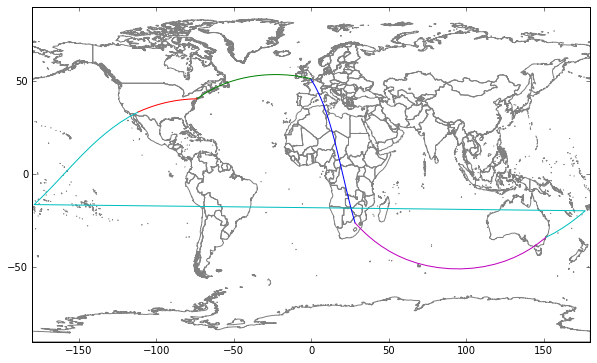

In [6]:
# Make a LineString for each leg, including the starting and ending points
points_in_path = 20
legs = []
full_path = []

coord_pairs = [(coords[shortest_order[i]],coords[shortest_order[i-1]]) for i in range(len(shortest_order))]
# Rotate list to better match the airport list
coord_pairs = coord_pairs[1:]+coord_pairs[:1]

# Make the leg LineStrings
# And a full-path list of points
g = pyproj.Geod(ellps='WGS84')
for p1,p2 in coord_pairs:
    # Add the first endpoint and PyProj's intermediate points
    flightpath = [p1]
    flightpath.extend(g.npts(*p1, *p2, points_in_path))
    
    # Add to the complete set of points in one list, without duplicating any airports
    full_path.extend(reversed(flightpath)) 
    
    # Then add the endpoint of this leg
    flightpath.append(p2)
    legs.append(LineString(flightpath))
#


# Plot the world
for country in country_shapes:
    try:
        plot(*country.exterior.xy, 'grey')
    except AttributeError: # MultiPolygons don't have .xy
        for geom in country.geoms:
            plot(*geom.exterior.xy, 'grey')
xlim(-180,180)
ylim(-90,90)

# And plot the path
for leg in legs:
    plot(*leg.xy)
#

### Make a version of the flightpath that skips the -180 - +180 boundary

[(180.0, -17.110256721057155)] [(-180.0, -17.110256721057155)]
Original path in red, new path in black, 180 boundary in green.


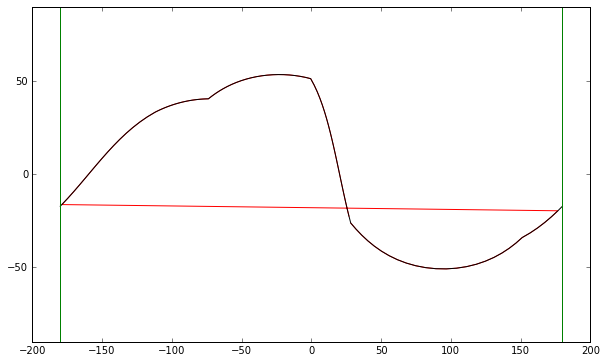

In [7]:
# Unmodified flight path
raw_route = LineString(full_path)

# Find the index of a -180/+180 crossing: sequential points are more than 300deg apart
# TODO: Modify this to handle multiple 180 boundary crossings?
split_idx = 0
for i in range(len(full_path)):
    if abs(full_path[i][0] - full_path[i-1][0]) > 300:
        split_idx = i
        break
#

# Add a couple of points at the intersection of lon +/-180 and the flight path.
# It looks like there's a small Pacific nation that should be in the flight path,
#  but the path stops too early...

# If path is in reverse order, reverse the signs in the following equations
mult = 1
if full_path[split_idx-1][0] > 0:
    mult = -1
#

# Make line segment from last <180 point to next point, modified to be >180
crosspath = LineString([full_path[split_idx],(full_path[split_idx-1][0]+360*mult, full_path[split_idx-1][1])])

# Get intersection points of those segments with the 180 boundary
cross_intersection = crosspath.intersection(LineString([(180*mult,90),(180*mult,-90)]))

# Convert to list-of-tuple-of-floats format
crosspoint1 = [(cross_intersection.x,cross_intersection.y)]
crosspoint2 = [(-cross_intersection.x,cross_intersection.y)]
print(crosspoint1, crosspoint2)

# Add extra points and re-order path to put the 180 crossing at the ends
unlooped_route = LineString(crosspoint1+full_path[split_idx:]+full_path[:split_idx]+crosspoint2)

# Plot the paths
print("Original path in red, new path in black, 180 boundary in green.")
xlim(-200,200)
ylim(-90,90)

plot(*raw_route.xy, 'r')
plot(*unlooped_route.xy, 'k')
#plot(*crosspath.xy, 'g')
plot(*(LineString([(180,90),(180,-90)]).xy), 'g')
plot(*(LineString([(-180,90),(-180,-90)]).xy), 'g')

### Iterate over countries, extract list of those that intersect route

### (Answer)

The flight path crosses these countries in some order:
- Angola
- Australia
- Botswana
- Central African Republic
- Canada
- Democratic Republic of the Congo
- Algeria
- France
- United Kingdom
- Ireland
- Libya
- Mexico
- Niger
- Chad
- Tunisia
- United States of America
- South Africa
- Zambia
- Zimbabwe


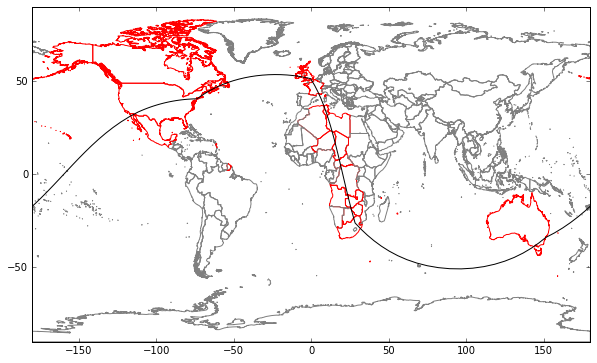

In [8]:
# crossed_countries = [f for f in country_shapes if f.crosses(unlooped_route)]

# I think I need to use a for loop, rather than list comprehension, in order to get the names
crossed_countries = []
crossed_country_indices = []
print("The flight path crosses these countries in some order:")
for i,geom in enumerate(country_shapes):
    if unlooped_route.crosses(geom):
        print("-",gj['features'][i]['properties']['ADMIN'])
        crossed_countries.append(geom)
        crossed_country_indices.append(i)
#

for i,country in enumerate(country_shapes):
    if i in crossed_country_indices:
        color = 'r'
    else:
        color = 'grey'
    try:
        plot(*country.exterior.xy, color)
    except AttributeError:
        for geom in country.geoms:
            plot(*geom.exterior.xy, color)
xlim(-180,180)
ylim(-90,90)
plot(*unlooped_route.xy, 'k')

### Somehow, the flight path misses every island in the Pacific...

...But at least my 180-crossing adjustment works!

(This miss persists even if `points_in_path` goes up to 2000, although not if `points_in_path` drops to 2)

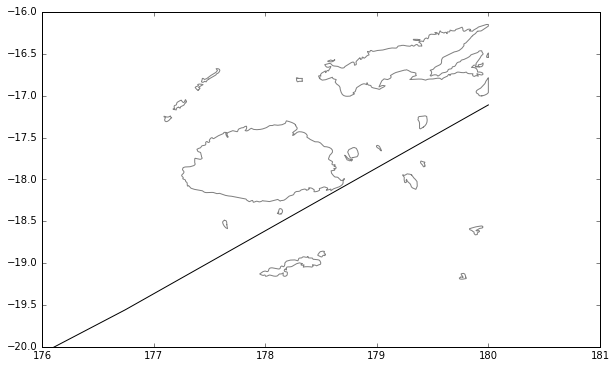

In [9]:
# 180 east
for i,country in enumerate(country_shapes):
    if i in crossed_country_indices:
        color = 'r'
    else:
        color = 'grey'
    try:
        plot(*country.exterior.xy, color)
    except AttributeError:
        for geom in country.geoms:
            plot(*geom.exterior.xy, color)
xlim(176,181)
ylim(-20,-16)
plot(*unlooped_route.xy, 'k')

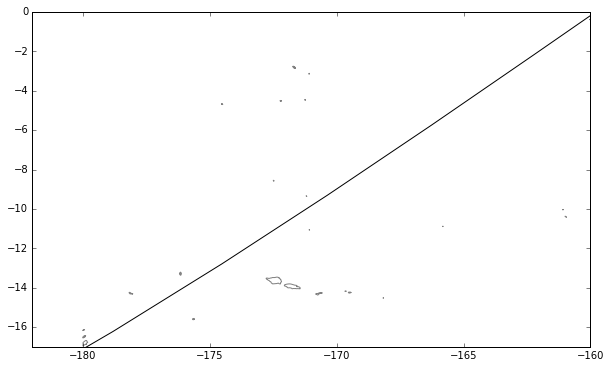

In [10]:
# 180 west
for i,country in enumerate(country_shapes):
    if i in crossed_country_indices:
        color = 'r'
    else:
        color = 'grey'
    try:
        plot(*country.exterior.xy, color)
    except AttributeError:
        for geom in country.geoms:
            plot(*geom.exterior.xy, color)
xlim(-182,-160)
ylim(-17,0)
plot(*unlooped_route.xy, 'k')